In this notebook I go through creating the MC versions of the existing differentiable model, and then compare it as is to the differentiable implementation, so far, just investigating the mean trends across time at fixed mass and several p50. I also include plots that compare the discrepancies in parameter distributions that define the two implementations.

In [2]:
import numpy as np
import matplotlib.pylab as plt
import jax
from jax import jit as jjit
from jax import numpy as jnp
from jax import vmap
from diffprof.latin_hypercube import latin_hypercube

plt.style.use('diffprof.mplstyle')

In [3]:
import matplotlib.cm as cm
from time import time
from matplotlib import lines as mlines

In [4]:
import importlib

In [5]:
p_best_target_data_model = np.load('conc_target_data_model_params.npy')
p_best_target_std_data_model = np.load('conc_target_std_data_model_params.npy')

N_TIMES = 25
tarr = np.linspace(2, 13.8, N_TIMES)
TARR_FIT = tarr

N_GRID = 250
N_MH = 15
N_P = 15
LGMH_MIN = 11.4
LGMH_MAX = 14.5
P50_MIN=0.1 
P50_MAX=0.9

In [6]:
from diffprof.fit_target_data_model import predict_targets
from diffprof.fit_target_std_data_model import predict_std_targets
from diffprof.diffconc_std_p50_model import _scatter_vs_p50_and_lgmhalo
from diffprof.conc_pop_model import get_u_param_grids

from diffprof.diffconc_std_p50_model import PARAMS as P50_SIG_PARAMS
p_best_target_std_data_p50_model = P50_SIG_PARAMS.values()

In [7]:
import global_differentiable_conc_model_full_DOF
get_default_params = global_differentiable_conc_model_full_DOF.get_default_params
_loss = global_differentiable_conc_model_full_DOF._loss
get_singlemass_params_p50 = global_differentiable_conc_model_full_DOF.get_singlemass_params_p50
get_predictions_from_singlemass_params_p50 = global_differentiable_conc_model_full_DOF.get_predictions_from_singlemass_params_p50
get_u_param_grids = global_differentiable_conc_model_full_DOF.get_u_param_grids

In [8]:
from conc_pop_model_full_DOF import get_pdf_weights_on_grid
from diffprof.nfw_evolution import DEFAULT_CONC_PARAMS
CONC_K = DEFAULT_CONC_PARAMS['conc_k']
from conc_pop_model_full_DOF import lgc_pop_vs_lgt_and_p50, get_param_grids_from_u_param_grids, mean_and_cov_u_lgtc_bl

In [9]:
u_be_grid, u_lgtc_bl_grid = get_u_param_grids(N_GRID)
p50_arr = jnp.sort(latin_hypercube(P50_MIN, P50_MAX, 1, N_P).flatten())
lgmasses = jnp.sort(latin_hypercube(LGMH_MIN, LGMH_MAX, 1, N_MH).flatten())

In [10]:
LGM = 13.5
PARAMS = np.load('global_diffprof_model_full_DOF_params1.npy')


im = np.argmin(np.abs(lgmasses - LGM))
    
full_params = PARAMS

singlemass_params_p50 = get_singlemass_params_p50(lgmasses[im],*full_params)
predictions_res = get_predictions_from_singlemass_params_p50(singlemass_params_p50,TARR_FIT, p50_arr, u_be_grid, u_lgtc_bl_grid)
pred_avg_log_conc_p50, pred_avg_log_conc, pred_log_conc_std, log_conc_std_p50 = predictions_res

#### Full calculation of differentiable in one place

In [11]:
N_GRID = 250
N_MH = 15
N_P = 15
LGMH_MIN = 11.4
LGMH_MAX = 14.5
P50_MIN=0.1 
P50_MAX=0.9

u_be_grid, u_lgtc_bl_grid = get_u_param_grids(N_GRID)
p50_arr = jnp.sort(latin_hypercube(P50_MIN, P50_MAX, 1, N_P).flatten())
lgmasses = jnp.sort(latin_hypercube(LGMH_MIN, LGMH_MAX, 1, N_MH).flatten())

LGM = 13.5
PARAMS = np.load('global_diffprof_model_full_DOF_params1.npy')


im = np.argmin(np.abs(lgmasses - LGM))
    
full_params = PARAMS

singlemass_params_p50 = get_singlemass_params_p50(lgmasses[im],*full_params)
predictions_res = get_predictions_from_singlemass_params_p50(singlemass_params_p50,TARR_FIT, p50_arr, u_be_grid, u_lgtc_bl_grid)
pred_avg_log_conc_p50, pred_avg_log_conc, pred_log_conc_std, log_conc_std_p50 = predictions_res

## Validation by monte carlo realizations

Here we will analytically compute the parameters for the singlemass model, and then use the code from this model to bypass the integration over parameter grids and directly sample points in the parameter space to create a subpopulation

In [76]:
means_and_covs_params = singlemass_params_p50[2:]
mean_u_lgtc, mean_u_bl, cov_u_lgtc_bl = mean_and_cov_u_lgtc_bl(p50_arr,*means_and_covs_params)
mu = [mean_u_lgtc, mean_u_bl]

mean_u_be = singlemass_params_p50[0]
lg_std_u_be = singlemass_params_p50[1]

In [77]:
## we first create an array of all of the unbounded parameters with shape N_P, n, N_times
## then use a vmap to compute all of the trajectories from there

n_sample = 15000

from diffprof.nfw_evolution import get_bounded_params
DEFAULT_U_K = -10.7613945 ## this is set to make the k = 5
model_cbe = []
model_conc_k = []
model_lgtc = []
model_cbl = []
model_u_cbe = []
model_u_conc_k = []
model_u_lgtc = []
model_u_cbl = []
for ip in range(len(p50_arr)):
    model_u_cbe_subpopulation = np.random.normal(loc=mean_u_be, scale=10**lg_std_u_be, size=n_sample)
    model_u_cbe.append(model_u_cbe_subpopulation)
    model_u_conc_k_subpopulation = np.full_like(model_u_cbe_subpopulation, DEFAULT_U_K)
    model_u_conc_k.append(model_u_conc_k_subpopulation)
    mu_subpopulation = [mu[0][ip],mu[1][ip]]
    cov = cov_u_lgtc_bl[ip]
    u_cbl_lgtc_sample_model = np.random.multivariate_normal(mu_subpopulation, cov, size=n_sample)
    model_u_lgtc_subpopulation = u_cbl_lgtc_sample_model[:,0]
    model_u_lgtc.append(model_u_lgtc_subpopulation)
    model_u_cbl_subpopulation = u_cbl_lgtc_sample_model[:,1]
    model_u_cbl.append(model_u_cbl_subpopulation)
    u_params = model_u_lgtc_subpopulation, model_u_conc_k_subpopulation, model_u_cbe_subpopulation, model_u_cbl_subpopulation
    params = get_bounded_params(u_params)
    conc_lgtc, conc_k, cbe, cbl = params
    
    model_lgtc.append(conc_lgtc)
    model_conc_k.append(conc_k)
    model_cbe.append(cbe)
    model_cbl.append(cbl)

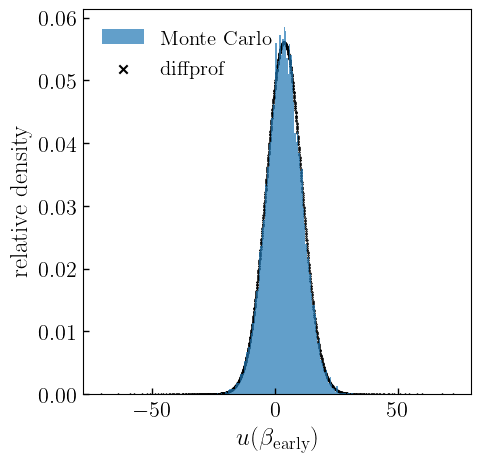

In [80]:
## plotting the difference between the MC and diffprof distributions for u_cbe

fig, ax = plt.subplots(1,1,figsize=(5,5))

_res = get_pdf_weights_on_grid(p50_arr, u_be_grid, u_lgtc_bl_grid, CONC_K, singlemass_params_p50)
u_be_weights, u_lgtc_bl_weights = _res

ax.hist(model_u_cbe[0],bins=100,density=True,alpha=0.7, label=r'$\rm Monte\ Carlo$')
ax.scatter(u_be_grid[:],u_be_weights[:,0]*22,marker='x',color='k',alpha=0.7,s=1)
ax.set_xlabel(r'$u(\beta_{\rm early})$')
ax.set_ylabel(r'${\rm relative\ density}$')
ax.scatter([],[],marker='x',color='k',label = r'$ \rm diffprof$')
ax.legend()
#fig.savefig('MC_v_diffprof_testing_u_be.png',dpi=300)
plt.show()

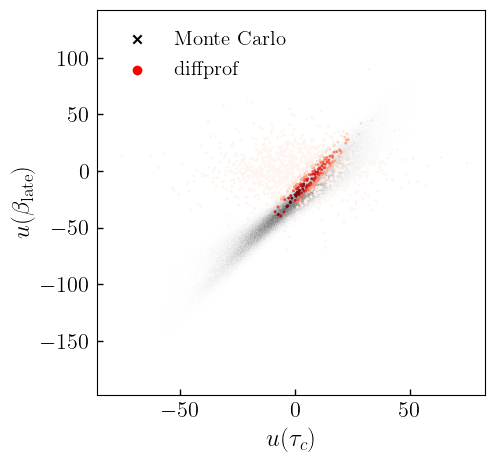

In [84]:
## this plot shows the distributions for u_cbl versus u_tauc for both the differentiable and MC versions

fig, ax = plt.subplots(1,1,figsize=(5,5))

ax.scatter(model_u_lgtc,model_u_cbl,marker='x',color='k',s=0.2,alpha=0.002)
ax.scatter(u_lgtc_bl_grid[:,0],u_lgtc_bl_grid[:,1],c= u_lgtc_bl_weights[:,0],s=1,cmap = 'Reds')

ax.scatter([],[],marker='x',color='k',label=r'$\rm Monte\ Carlo$')
ax.scatter([],[],color='red',label=r'$\rm diffprof$')
ax.legend()
ax.set_xlabel(r'$u(\tau_c)$')
ax.set_ylabel(r'$u(\beta_{\rm late})$')
#fig.savefig('MC_v_diffprof_ulgtc_bl_test.png',dpi=300)
plt.show()

Just looking briefly at the parameters and bounds

In [12]:
from diffprof.nfw_evolution import CONC_PARAM_BOUNDS
from diffprof.nfw_evolution import DEFAULT_CONC_PARAMS

In [86]:
CONC_PARAM_BOUNDS

OrderedDict([('conc_lgtc', (0.0, 1.5)),
             ('conc_k', (0.25, 15.0)),
             ('conc_beta_early',
              (DeviceArray(0.30102998, dtype=float32), 0.75)),
             ('conc_beta_late',
              (DeviceArray(0.30102998, dtype=float32), 2.5))])

In [13]:
DEFAULT_CONC_PARAMS

OrderedDict([('conc_lgtc', 0.8),
             ('conc_k', 5.0),
             ('conc_beta_early', 0.35),
             ('conc_beta_late', 1.2)])

In [87]:
from diffprof.nfw_evolution import lgc_vs_lgt
lgc_vs_lgt_vmap = jjit(vmap(lgc_vs_lgt, in_axes=(None, 0, 0, 0, 0)))

subpopulations_p50 = []
for ip in range(len(p50_arr)):
    conc_lgtc, conc_k, cbe, cbl = model_lgtc[ip], model_conc_k[ip], model_cbe[ip], model_cbl[ip]
    conc_k = np.full_like(cbe, 5)#### the differentiable version uses k=5, but the original MC version used k=4
    subpopulation = 10**lgc_vs_lgt_vmap(np.log10(TARR_FIT), conc_lgtc, conc_k, cbe, cbl)
    subpopulations_p50.append(subpopulation)

Checking to make sure the trajectories seems sensible for the MC version

In [14]:
## this is a plot of all of the MC trajectories for a given percentile and mass

fig,ax = plt.subplots(1,1,figsize = (5,5))

ip = np.argmin(np.abs(p50_arr- 0.1))

for i in range(n_sample):
    ax.plot(TARR_FIT,subpopulations_p50[ip][i][:],alpha=0.01,color='tab:orange')
    
ax.set_xlim(0,13)
ax.set_ylim(0,16)
plt.show()

NameError: name 'n_sample' is not defined

### Calculating the Monte Carlo values for means, standard deviations

In [88]:
mean_log_conc_p50_MC = np.mean(np.log10(subpopulations_p50), axis = 1)
mean_log_conc_MC = np.mean(mean_log_conc_p50_MC, axis = 0)

population = []
for subpop in subpopulations_p50:
    population += subpop

std_log_conc_MC = np.std(np.log10(population),axis = 0)
std_log_conc_p50_MC = np.std(np.log10(subpopulations_p50),axis = 1)

In [15]:
# Plotting both the mean trajectories for the MC and differentiable versions

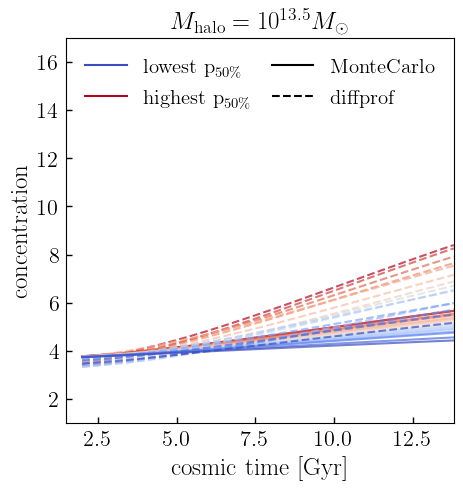

In [101]:
fig, ax = plt.subplots(1,1,figsize = (5,5))

#im = np.argmin(np.abs(lgmasses - LGM))

full_params = PARAMS

singlemass_params_p50 = get_singlemass_params_p50(lgmasses[im],*full_params)
predictions_res = get_predictions_from_singlemass_params_p50(singlemass_params_p50,TARR_FIT, p50_arr, u_be_grid, u_lgtc_bl_grid)
pred_avg_log_conc_p50, pred_avg_log_conc, pred_log_conc_std, log_conc_std_p50 = predictions_res

import matplotlib.cm as cm
from matplotlib import lines as mlines
colormap_seq=np.linspace(1, 0, N_P)
colors=cm.coolwarm(colormap_seq)

#yscale = ax.set_yscale('log')
ylim = ax.set_ylim(1, 17)
xlim = ax.set_xlim(1.5, 13.8)
for ip50 in range(N_P):
    __=ax.plot(TARR_FIT, 10**pred_avg_log_conc_p50[ip50, :], color=colors[ip50],alpha=0.7,linestyle='--')
    __=ax.plot(TARR_FIT, 10**mean_log_conc_p50_MC[ip50, :], color=colors[ip50],alpha=0.7,linestyle='-')
__=ax.set_xlabel(r'$\rm cosmic\ time\ [Gyr]$')
__=ax.set_title(r'$M_{\rm halo} = 10^{'+str(LGM)+r'}M_{\odot}$')

diff=mlines.Line2D([],[],linestyle='--',color='k',label=r'$\rm diffprof$')
MC=mlines.Line2D([],[],linestyle='-',color='k',label=r'$\rm Monte Carlo$')

red_line=mlines.Line2D([],[],ls='-',c=colors[-1],label=r'${\rm lowest\ p_{50\%}}$')
blue_line=mlines.Line2D([],[],ls='-',c=colors[0],label=r'${\rm highest\ p_{50\%}}$')
leg=ax.legend(handles=[red_line, blue_line], loc='upper left')
leg2=ax.legend(handles=[MC,diff])
plt.gca().add_artist(leg)

ax.set_ylabel(r'${\rm concentration}$')
#fig.savefig('MC_v_diffprof_mean_conc_trajectories_p50.png',dpi=300)
plt.show()